# Alzheimer's Disease Prediction
In this project I have taken a dataset with images classified into four different stages of alzheimer's disease, and created a classifier capable of sorting each image into one of the four stages. Some of the main takeaways of this project are:
* Using different transformations for data augmentation to increase the amount of images the model sees, as the dataset is imbalanced and rather limited and it tends to overfit quickly. (Some transformations such as Cutout have proved very useful)
* Using Progressive Resizing to train the model, this also helps us increase the accuracy of the final model, and decreases the amount of epochs we neet to train on the full size model, decreasing the computational needs of training.
* Using tranfer learning from pretrained models, in this case I imported a pretrained VGG16 model. Despite being originally trained on ImageNet
dataset, can be repurposed for disease recognition b 
transfer learning the network on a dataset consisti g
of MRI imag
* After the model training and testing I have also added a function to visualize the CAM (Class Activation Maps) Which can be interesting to see why is the model classifying each image as it is. Further investigation into this area is needed to really understand the reasons for the model classifications, and improving the CAM function.s. 

In [2]:
import numpy as np
import pandas as pd
import os
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.data.all import *
from fastai.vision.all import *
from pyxtend import struct
from albumentations import CoarseDropout

In [3]:
import fastai
print('The version of FastAI being used is:',fastai.__version__)

The version of FastAI being used is: 2.7.15


In [4]:
import torch
print('Cuda available: ',torch.cuda.is_available())
print('GPU name: ', torch.cuda.get_device_name(0))

Cuda available:  True
GPU name:  NVIDIA GeForce GTX 1050


In [5]:
PATH = 'AlzheimersDataset/train'

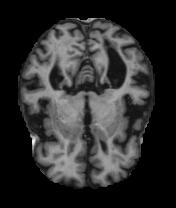

In [6]:
items = get_image_files(PATH)
img = PILImage.create(items[0])
img

## Loading the data from the AlzheimersDataset directory

Progressive Resizing involves pretraining a model on shrunken versions of images (in this case, down to size 112x112) and then retraining the model on the full sized images.

In [7]:
splitter = RandomSplitter(valid_pct=0.2)

We will use a Random Splitter to generate a training set and a validation set from our data.

In [8]:
class AlbumentationsTransform(DisplayedTransform):
    split_idx,order=0,2
    def __init__(self, train_aug): store_attr()
    
    def encodes(self, img: PILImage):
        aug_img = self.train_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [9]:
cutout = CoarseDropout(num_holes_range=(1, 3), hole_height_range=(5, 5), hole_width_range=(5, 5), p=0.8)

In [10]:
transforms = aug_transforms(max_rotate = 7.5,
                            max_zoom = 1.15,
                            max_lighting = 0.15,
                            max_warp = 0.15,
                            p_affine = 0.8, p_lighting = 0.8,
                            pad_mode = 'zeros')

Defining the transformations we will perform on the training set using it as a data augmentation technique

In [11]:
dblock = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = parent_label,
    splitter = splitter,
    item_tfms = [Resize(112), AlbumentationsTransform(cutout)],
    batch_tfms = [*transforms, Normalize.from_stats(*imagenet_stats)])

The DataBlock object acts as the instructions given to the DataLoader when loading the data but itself does not contain any data. We are going to use progressive resizing, our first image size is 112x112, which is why we use the Resize(112) function.

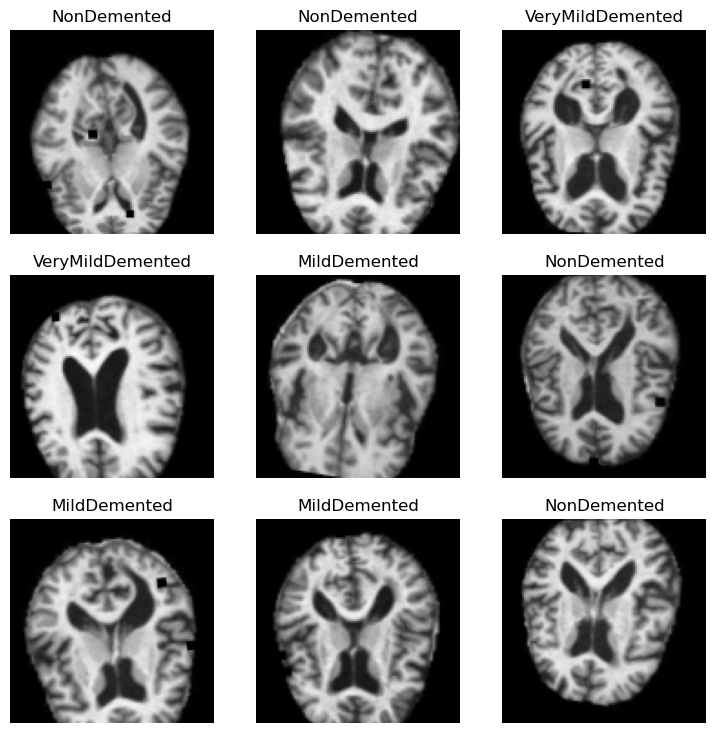

In [38]:
dls = dblock.dataloaders(PATH)
dls.train.show_batch()

We can then create a DataLoader object and give it the path to the data directory, when we visualize a batch we can see some of the images with the transformations already applied, if we visualized the validation set we could see no transformations have been applied to itm except for resizing.

In [13]:
learn = vision_learner(dls,
                       models.vgg16_bn,
                       cbs = [ShowGraphCallback()],
                       wd=1e-1,
                       metrics=[F1Score(average='weighted'), accuracy])

We are then going to create our learner with the dataloader as input and a vgg16 pretrained model as our initial estimator.

SuggestedLRs(valley=0.0012022644514217973)

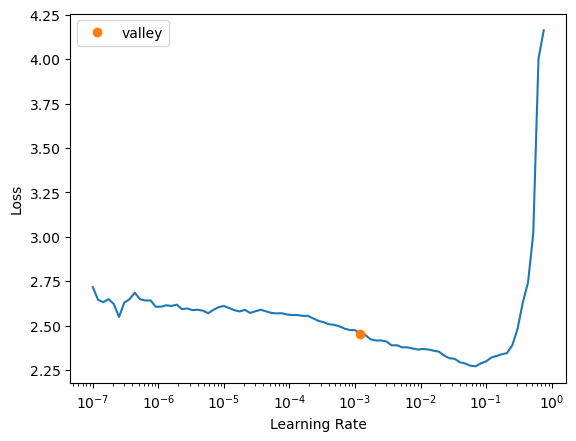

In [20]:
learn.lr_find()

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,2.059829,1.378007,0.531738,0.512695,01:22
1,1.654866,1.004019,0.596359,0.605469,03:35
2,1.412372,0.930253,0.615799,0.625000,04:31
3,1.220544,0.909533,0.624875,0.632812,04:33


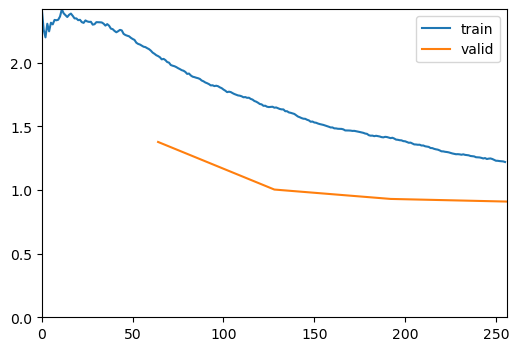

In [21]:
learn.fit_one_cycle(4, 1e-3)

In [22]:
learn.save('working/Alzheimers112')

Path('models/working/Alzheimers112.pth')

In [14]:
learn.load('working/Alzheimers112')

In [39]:
learn.unfreeze()

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,1.162592,0.860945,0.618685,0.629883,05:34
1,1.078093,0.859237,0.626806,0.641602,06:10
2,1.005352,0.815493,0.653244,0.664062,06:10
3,0.975910,0.809017,0.643372,0.656250,06:10


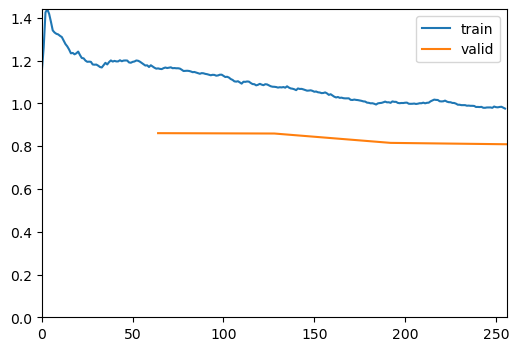

In [29]:
learn.fit_one_cycle(4, lr_max=slice(1e-6,3e-4))

In [30]:
learn.save('working/Alzheimers112_2')

Path('models/working/Alzheimers112_2.pth')

In [17]:
learn.load('working/Alzheimers112_2')

We have trained the model for 2 cycles with our downsized images, when doing progressive resizing it is better to leave the model underfit, to make sure we still have room to improve the model without overfitting with the full size images.

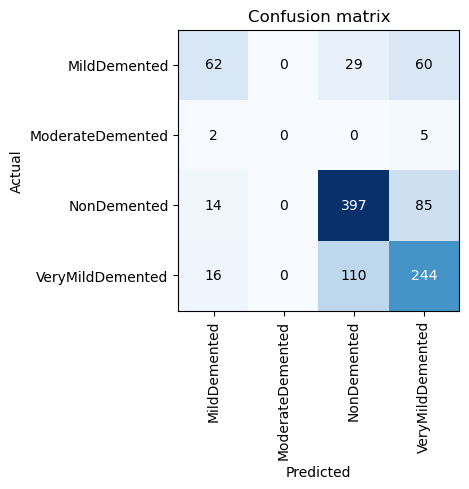

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

As you can see from the confusion matrix we have a decent model with the small images we can now use as starting point for the full size model.

# USING FULL SIZE IMAGES

In [24]:
del learn 
torch.cuda.empty_cache()

In [25]:
cutout_full = CoarseDropout(num_holes_range=(1, 6), hole_height_range=(5, 20), hole_width_range=(5, 20), p=0.8)

We need to create a new cutout transformation because the images are now bigger, we will make the holes bigger.

In [26]:
dblock_full = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = parent_label,
    splitter = splitter,
    item_tfms = [Resize(224), AlbumentationsTransform(cutout_full)],
    batch_tfms = [*transforms, Normalize.from_stats(*imagenet_stats)])

In the new DataBlock object we apply the new cutout transformation and we also change the Resize function to use full size images (224x224)

In [27]:
dls_full = dblock_full.dataloaders(PATH, bs=32)

In [28]:
dls_full.train.bs

32

In [29]:
learn = vision_learner(dls_full,
                       models.vgg16_bn,
                       cbs = [ShowGraphCallback()],
                       pretrained = False,
                       wd=1e-1,
                       metrics=[F1Score(average='weighted'), accuracy])

In [16]:
learn.load('working/Alzheimers112_2')

In [ ]:
learn.fit_one_cycle(15, lr_max=5e-4)

In [18]:
learn.save('working/Alzheimers224_15')

Path('models/working/Alzheimers224_15.pth')

In [30]:
learn.load('working/Alzheimers224_15')

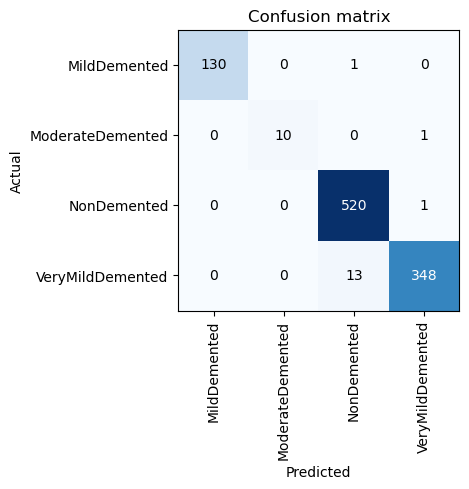

In [31]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

After training the model with a smaller learning rate than before but for longer (15 epochs) we can see we have obtained a very good model and improved the model obtained with the smaller sized images.

## CAM Visualization 
 We have a function which shows what areas of the image contributed the most to the appropriate diagnostic. With this method, one can view an image, see what the algorithmn predicted and why. This can help humans involved in the diagnostic process get a second opinion or bring attention high risk areas.

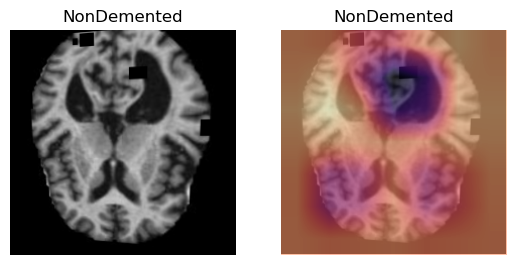

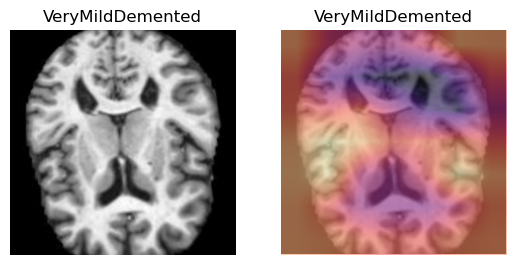

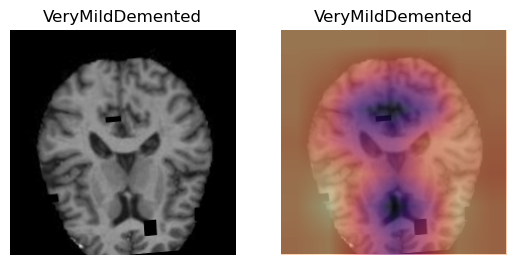

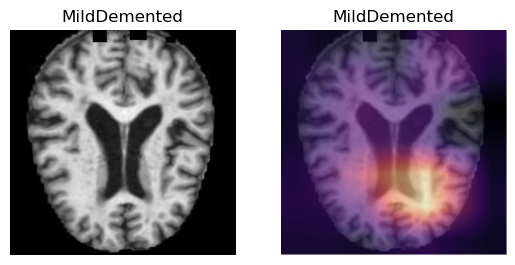

In [36]:
def visualize_cnn_by_cam(learn, data_index):
    x, _y = learn.dls.valid_ds[data_index]
    y = _y.data
    
    if not isinstance(y, (list, np.ndarray)): # single label -> one hot encoding
        y = np.eye(learn.dls.valid_ds.c)[y]

    m = learn.model.eval()
    xb,_ = learn.dls.one_batch()
    xb_im = learn.dls.decode((xb,))[0][0]
    xb = xb.cuda()

    def hooked_backward(cat):
        with hook_output(m[0]) as hook_a: 
            with hook_output(m[0], grad=True) as hook_g:
                preds = m(xb)
                preds[0,int(cat)].backward()
        return hook_a,hook_g
        
    def show_heatmap(img, hm, label):
        _,axs = plt.subplots(1, 2)
        axs[0].set_title(label)
        img.show(axs[0])
        axs[1].set_title(label)
        img.show(axs[1])
        axs[1].imshow(hm, alpha=0.6, extent=(0,img.shape[1],img.shape[1],0),
                      interpolation='bilinear', cmap='magma');
        plt.show()

    for y_i in np.where(y > 0)[0]:
        hook_a,hook_g = hooked_backward(cat=y_i)
        acts = hook_a.stored[0].cpu()
        grad = hook_g.stored[0][0].cpu()
        grad_chan = grad.mean(1).mean(1)
        mult = (acts*grad_chan[...,None,None]).mean(0)
        show_heatmap(img=xb_im, hm=mult, label=str(learn.dls.vocab[y_i]))

idx_list = [0,95,100,125]  
for idx in idx_list:# range(10):
    visualize_cnn_by_cam(learn, idx)